# Part 0: Requirements

In [8]:
# Allow python to import modules from src folders
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import ast
sys.path.append("src/")

from preprocessing.load_dataset import *

## Download data  
Please uncomment the following line to download data

In [9]:
# %run src/preprocessing/download_dataset.py

# Part I: Load, explore and join datasets

## CMU dataset

We load the 4 `.tsv` and `.txt` files of the CMU dataset into 4 different dataframes

In [10]:
characters_df = load_characters_df()
movies_df = load_movies_df()
plot_df = load_plot_df()
tvtropes_df = load_tvtropes_df()

### Characters

In [11]:
characters_df.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
267144,92689,/m/0n05v,1984-03-11,Asbel,1986-06-11,M,1.759,/m/041rx,Shia LaBeouf,-2.0,/m/0cgncqj,/m/0gxmvl6,/m/04w391
343336,1380847,/m/04y338,2003-05-18,Jessie Burlingame,1980-12-30,F,1.650,/m/0ffhz3,Eliza Dushku,22.0,/m/0k86lg,/m/0b4ctyx,/m/01jb26
36042,16812698,/m/04073ht,1936-03-21,NaN,1904-11-14,M,1.830,NaN,Dick Powell,31.0,/m/04dgsj4,NaN,/m/01d5vk
254732,4967085,/m/0cxl4q,2006,NaN,NaN,M,NaN,NaN,Scott Koblish,NaN,/m/0jt1cj,NaN,/m/0jt181
236672,14222062,/m/03cy7wz,1974-04-15,NaN,NaN,M,NaN,NaN,Aleksandras Ribaitis,NaN,/m/0mv2dvm,NaN,/m/0mv2dvq


In [12]:
total_characters = len(characters_df)
print(f"Number of characters loaded: {total_characters}")
print(f"Number of unique movies: {len(characters_df['wiki_movie_id'].unique())}")
print(f"Number of unique actors: {len(characters_df['freebase_actor_id'].unique())}", end="\n\n")

print(f"Percentage of missing gender: {characters_df['actor_gender'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing height: {characters_df['actor_height'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing ethnicity: {characters_df['actor_ethnicity'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing age upon release: {characters_df['release_actor_age'].isna().sum()/total_characters*100:.2f}%")

Number of characters loaded: 450669
Number of unique movies: 64330
Number of unique actors: 135761

Percentage of missing gender: 10.12%
Percentage of missing height: 65.65%
Percentage of missing ethnicity: 76.47%
Percentage of missing age upon release: 35.08%


In [13]:
print(f"Number of character records for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()])}")
print(f"Number of unique actors for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()]['freebase_actor_id'].unique())}")

Number of character records for which ethnicity is known: 106058
Number of unique actors for which ethnicity is known: 8151


### Movies

In [14]:
movies_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres
29025,32072725,/m/0gx0d9_,The Nipper,1930-06,NaN,81.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/04t36': 'Musical'}
64063,11153699,/m/02r1vk7,I Really Hate My Job,2007,NaN,89.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/0hj3nyp': 'Workplace Comedy', '/m/01z4y':..."
51704,26978693,/m/0bj77wg,The Princess of Montpensier,2010-05-16,NaN,139.0,{'/m/064_8sq': 'French Language'},"{'/m/0f8l9c': 'France', '/m/0345h': 'Germany'}","{'/m/03g3w': 'History', '/m/02l7c8': 'Romance ..."
42109,25610771,/m/09v7bvl,The Girl from Corfu,1956,NaN,81.0,{},{'/m/035qy': 'Greece'},"{'/m/04t36': 'Musical', '/m/02l7c8': 'Romance ..."
28646,13651637,/m/03cd317,So Close to Paradise,2001-03-09,NaN,90.0,"{'/m/01r2l': 'Chinese language', '/m/0653m': '...",{'/m/0d05w3': 'China'},"{'/m/068d7h': 'Romantic drama', '/m/07s9rl0': ..."


In [15]:
total_movies = len(movies_df)
print(f"Number of movies loaded: {total_movies}")
print(f"Percentage of missing box office revenue: {movies_df['box_office'].isna().sum()/total_movies*100:.2f}%")

Number of movies loaded: 81741
Percentage of missing box office revenue: 89.72%


In [16]:
print(f"Number of movies for which we have matching character data: {len(movies_df.merge(characters_df, how='inner', on=['wiki_movie_id', 'freebase_movie_id'])['freebase_movie_id'].unique())}")

Number of movies for which we have matching character data: 64330


In [17]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)

# Fix data aberration
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index

# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

### Plot

In [18]:
plot_df.sample(5)

,wiki_movie_id,plot_summary
30359,32895002,"In the south coast of England, a young woman, ..."
7942,3740032,Steve Randall is an independent trucker who i...
37811,438548,The film opens at Blackadder Hall where the pr...
20673,12626400,Hayley Mills plays a seventeen year-old young ...
22368,5480296,Véronique gives a mathematics lesson to a dunc...


In [19]:
total_plot = len(plot_df)
print(f"Number of plot summaries loaded: {total_plot}")

Number of plot summaries loaded: 42303


### Tropes

In [20]:
tvtropes_df.sample(5)

,trope_name,character_data
116,corrupt_corporate_executive,"{'char': 'Conal Cochran', 'movie': 'Halloween ..."
67,byronic_hero,"{'char': 'Martin Q. Blank', 'movie': 'Grosse P..."
481,valley_girl,"{'char': 'Cher Horowitz', 'movie': 'Clueless',..."
47,broken_bird,"{'char': 'Chelsea Deardon', 'movie': 'Legal Ea..."
386,psycho_for_hire,"{'char': 'Anton Chigurh', 'movie': 'No Country..."


In [21]:
total_tropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tropes}")

Number of tropes loaded: 501


## IMDB dataset

We load the 4 `.tsv` files of the IMDB dataset into 4 different dataframes

In [22]:
imdb_ratings_df = load_imdb_ratings()
imdb_title_df = load_imdb_title_basics()
imdb_principals_df = load_imdb_title_principals()
imdb_people_df = load_imdb_person_basics()

### Ratings

In [23]:
imdb_ratings_df.sample(5)

,tconst,averageRating,numVotes
743175,tt1582198,3.8,969
882914,tt2181245,8.8,10
85814,tt0115186,6.9,27
1230842,tt6644070,5.2,161
561490,tt1198094,4.8,42


We have 1367491 movies for which we have a rating.


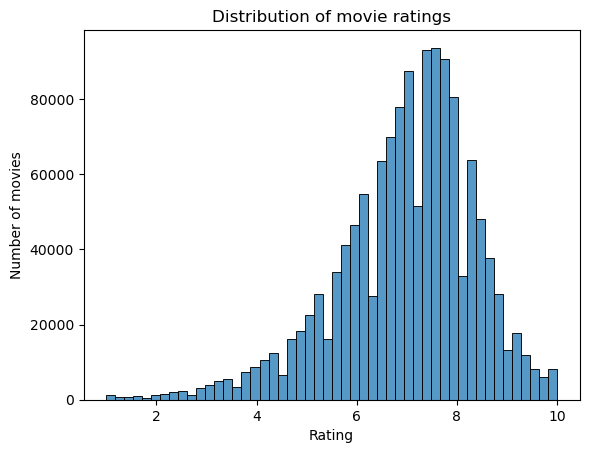

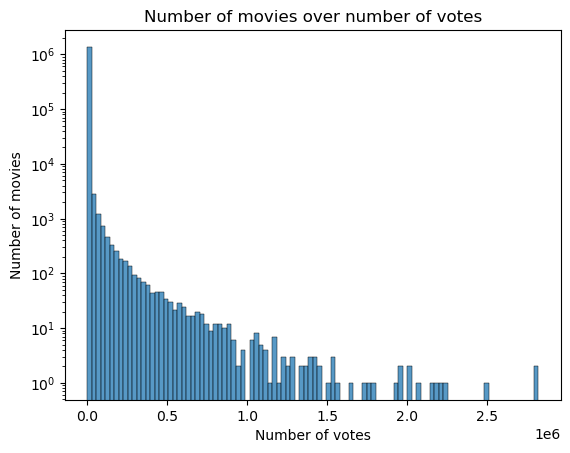

In [24]:
total_ratings = len(imdb_ratings_df)
print(f"We have {total_ratings} movies for which we have a rating.")

# Check the distribution of grades
sns.histplot(data=imdb_ratings_df, x="averageRating", bins=50)

plt.title("Distribution of movie ratings")
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.show()

# Check the distribution of votes
sns.histplot(data=imdb_ratings_df, x="numVotes", bins=100)
plt.yscale("log")

plt.title("Number of movies over number of votes")
plt.xlabel("Number of votes")
plt.ylabel("Number of movies")
plt.show()

### Title

In [25]:
imdb_title_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
169775,tt0175891,movie,Marie,Marie,0,1964,\N,\N,Drama
8718678,tt6449060,movie,L'Apprenti Pere Noel 2,L'Apprenti Pere Noel 2,0,2013,\N,\N,\N
5470708,tt21344756,movie,Something's on the Roof,Something's on the Roof,0,\N,\N,\N,"Horror,Thriller"
92836,tt0094939,movie,Daffy Duck's Quackbusters,Daffy Duck's Quackbusters,0,1988,\N,78,"Action,Adventure,Animation"
1808143,tt11515468,movie,The Struggle II: The Dilemma,The Struggle II: The Dilemma,0,2021,\N,105,Crime


In [26]:
# Remove adult content
imdb_title_df = imdb_title_df[imdb_title_df["isAdult"].astype(int) == 0]

In [27]:
total_title = len(imdb_title_df)
print(f"We have {total_title} movie titles")

We have 652592 movie titles


### Principals

In [28]:
imdb_principals_df.sample(5)

,tconst,ordering,nconst,category,job,characters
11750651,tt1125990,3,nm0934119,actor,\N,"[""Martin Platt""]"
7669184,tt10072640,10,nm12165838,writer,writer,\N
54811467,tt8474610,2,nm9100428,cinematographer,\N,\N
53401012,tt7977482,2,nm0328355,actress,\N,"[""Emilia""]"
55132935,tt8590212,6,nm2020904,writer,\N,\N


In [29]:
total_principals = len(imdb_principals_df)
print(f"We have {total_principals} principals records")
print(f"We have {len(imdb_principals_df['category'].unique())} categories")
print(f"We have {len(imdb_principals_df['nconst'].unique())} unique persons")


We have 59010065 principals records
We have 12 categories
We have 5176801 unique persons


In [30]:
missing_characters = len(imdb_principals_df[imdb_principals_df['characters'] == "\\N"])
print(f"We have {missing_characters/total_principals*100:.2f}% of missing characters")

We have 51.89% of missing characters


### People

In [31]:
imdb_people_df.sample(5)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
5720781,nm1516933,Karen Vered,\N,\N,actress,tt0223503
8178867,nm4027383,Akanksha Gupta,\N,\N,"actor,writer,miscellaneous",tt1707672
11199344,nm7767921,Darina Nicová,1981,\N,actress,"tt9466748,tt9028730,tt3037336,tt0230652"
9778875,nm5902593,Elio Finestauri,\N,\N,editorial_department,tt0045247
8794479,nm4754271,Andy Cernera,\N,\N,actor,tt2100422


In [32]:
total_people = len(imdb_people_df)
print(f"We have {total_people} people records")
print(f"We have {len(imdb_people_df['nconst'].unique())} unique persons")
print(f"We have {len(imdb_people_df[imdb_people_df['primaryProfession'] == 'actor'])} unique actors")

We have 12997049 people records
We have 12997049 unique persons
We have 2347021 unique actors


### Movie titles with ratings

In [33]:
imdb_title_with_rating = imdb_title_df.merge(imdb_ratings_df, on='tconst', how='inner')
imdb_title_with_rating.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
234850,tt3171674,movie,Hudugaata,Hudugaata,0,2007,\N,143,"Comedy,Drama",7.0,78
265359,tt5873216,movie,They,They,0,2017,\N,80,Drama,4.8,597
260423,tt5373180,movie,Dolores,Dolores,0,2016,\N,98,"Drama,History,Romance",5.9,44
22657,tt0049080,movie,Città di notte,Città di notte,0,1957,\N,110,Drama,6.2,16
190598,tt16443062,movie,Syahadan,Syahadan,0,2022,\N,96,"Action,Adventure,Drama",3.8,32


In [34]:
total_movies_w_rating = len(imdb_title_with_rating)
print(f"We have {total_movies_w_rating} movies with ratings")

We have 295106 movies with ratings


## Merge CMU movies and plot summaries with IMDB titles and ratings

The translation dataframe from wikidata, which includes both the IMDB id and the Freebase id, enables us to combine the IMDB dataset with the CMU dataset

In [35]:
translation_id = load_translation_df()

In [36]:
imdb_title_with_rating_translated = imdb_title_with_rating.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_title_with_rating_translated = imdb_title_with_rating_translated.drop(["imdb_id"], axis=1)

In [43]:
cmu_movies_w_imdb_rating = imdb_title_with_rating_translated.merge(movies_df, how='inner', left_on='freebase_id', right_on='freebase_movie_id').copy()

In [44]:
# IMDB start year has no missing data, so we insert it into "NaN" fields of "movie_release_date" and drop "startYear"
missing_years = cmu_movies_w_imdb_rating[cmu_movies_w_imdb_rating['movie_release_date'].isna()].index
cmu_movies_w_imdb_rating.loc[missing_years, 'movie_release_date'] = cmu_movies_w_imdb_rating.loc[missing_years, 'startYear']

In [45]:
# We have MANY depulicated attributes
# We evaluated for each pair which column had more missing data and dropped it in favor of the other
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop(["freebase_movie_id", "titleType", "isAdult", "endYear", "primaryTitle", "originalTitle", "movie_release_year", "movie_runtime", "startYear"], axis=1)

In [46]:
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop_duplicates("tconst")
print(f"The merged dataframe contains {len(cmu_movies_w_imdb_rating)} movies with corresponding ratings")

The merged dataframe contains 44474 movies with corresponding ratings


In [60]:
# Add summaries
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.merge(plot_df, on="wiki_movie_id", how="left")

In [61]:
cmu_movies_w_imdb_rating.sample(5)

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
23721,tt0105521,501,Documentary,7.8,121,/m/063z91d,22954424,Taiga,1992,NaN,{},{'/m/0345h': 'Germany'},{'/m/0jtdp': 'Documentary'},NaN
42880,tt1663631,95,Comedy,4.0,586,/m/0glt1gv,31519851,Crazy Eyes,2012-03-11,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/05p553': 'Comedy film', '/m/07s9rl0': 'Dr...","Zack is a young, divorced father who starts t..."
40682,tt1249415,81,Documentary,6.4,548,/m/09k5mp4,25398241,OceanWorld 3D,2009,NaN,{},{'/m/07ssc': 'United Kingdom'},{'/m/0jtdp': 'Documentary'},NaN
14154,tt0062376,105,Drama,7.6,19805,/m/018zck,182737,"To Sir, with Love",1967-06-14,NaN,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/07s9rl0': 'Drama', '/m/01j1n2': 'Coming o...",{{plot}} Mark Thackeray is beginning his teac...
40142,tt1174042,96,"Comedy,Drama,Romance",6.3,4578,/m/0cj7gwd,33090868,The Myth of the American Sleepover,2010-05-17,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/0219x_': 'Indie', '/m/01t_vv': 'Comedy-dr...",The plot follows four young people as they nav...


## Merge IMDB people and principals

In [62]:
titles_of_interest = cmu_movies_w_imdb_rating["tconst"].to_list()

In [63]:
imdb_actors = imdb_people_df[(imdb_people_df["primaryProfession"].str.contains("actor")) | (imdb_people_df["primaryProfession"].str.contains("actoress"))].copy()

In [64]:
imdb_principals_actors = imdb_principals_df[(imdb_principals_df["category"] == "actress") | (imdb_principals_df["category"] == "actor")].copy()

In [65]:
imdb_actors_and_characters = imdb_actors.merge(imdb_principals_actors, on="nconst", how="inner").copy()

In [66]:
imdb_actors_and_characters = imdb_actors_and_characters[imdb_actors_and_characters["tconst"].isin(titles_of_interest)]

In [67]:
imdb_actors_and_characters = imdb_actors_and_characters.drop(["ordering", "category", "job", "primaryProfession"], axis=1)

In [68]:
imdb_actors_and_characters.head(5)

,nconst,primaryName,birthYear,deathYear,knownForTitles,tconst,characters
0,nm0000001,Fred Astaire,1899,1987,"tt0045537,tt0053137,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]"
1,nm0000001,Fred Astaire,1899,1987,"tt0045537,tt0053137,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]"
2,nm0000001,Fred Astaire,1899,1987,"tt0045537,tt0053137,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]"
3,nm0000001,Fred Astaire,1899,1987,"tt0045537,tt0053137,tt0050419,tt0072308",tt0027630,"[""Bake Baker""]"
4,nm0000001,Fred Astaire,1899,1987,"tt0045537,tt0053137,tt0050419,tt0072308",tt0028333,"[""Lucky Garnett""]"


## Filter CMU characters

In [69]:
titles_of_interest_wiki = cmu_movies_w_imdb_rating["wiki_movie_id"].to_list()

In [70]:
characters_interest = characters_df[characters_df["wiki_movie_id"].isin(titles_of_interest_wiki)]

In [71]:
characters_interest.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
34930,33336349,/m/0h4y6y7,2012-11-29,Mr. Peters,1955-02-15,M,1.91,NaN,Christopher McDonald,57.0,/m/0hgt6ss,/m/0hgt6sw,/m/06z8gn
110371,15132975,/m/03hjl8h,1980,NaN,NaN,M,NaN,NaN,Fred Carney,NaN,/m/0gc51m9,NaN,/m/0gbww35
74360,25703368,/m/09v85xn,1959-06,Werks-Pförtner,1900-04-28,M,NaN,NaN,Josef Sieber,NaN,/m/0n9d1lj,/m/0n9d1lm,/m/0dd96fx
85634,16083779,/m/03qnn42,1982-07-23,Boxer,NaN,M,NaN,NaN,Akio Kameda,NaN,/m/0n4nj6q,/m/0n4nj6t,/m/0n4nj70
271048,12034233,/m/04j2xg_,1987,NaN,NaN,NaN,NaN,NaN,Maria Socas,NaN,/m/0gcpk_m,NaN,/m/0gc6txh


## Merge IMDB actors and characters with CMU characters

In [72]:
imdb_actors_and_characters_translated = imdb_actors_and_characters.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.drop(["imdb_id"], axis=1)

In [73]:
# TODO, currently merging on movie id and actor name. Would rather merge with actor id too but a translation is needed
imdb_actors_w_cmu_characters = imdb_actors_and_characters_translated.merge(characters_interest, how='inner', left_on=['freebase_id', 'primaryName'], right_on=['freebase_movie_id', 'actor_name']).copy()

# Merge birth year information
missing_birth_years = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['actor_birth'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_birth_years, 'actor_birth'] = imdb_actors_w_cmu_characters.loc[missing_birth_years, 'birthYear']

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop(["freebase_movie_id", "primaryName", "deathYear", "birthYear", "character_name"], axis=1)

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop_duplicates()

imdb_actors_w_cmu_characters.sample(5)

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
41015,nm0039498,"tt0069848,tt0068285,tt0141926,tt0071357",tt0075113,"[""Ray Fay""]",/m/0dj777,5379548,1976,1950-10-12,M,NaN,NaN,Robin Askwith,25.0,/m/02vc42r,NaN,/m/04q3yn
60539,nm0382381,"tt1810592,tt0038821,tt28589996,tt1809348",tt0038821,"[""Bill Parsons""]",/m/098c79,3376392,1946,1897,M,NaN,NaN,John Nugent Hayward,NaN,/m/0k61tj,NaN,/m/0k61sn
7758,nm0000156,"tt0091064,tt0107290,tt0116629,tt2278388",tt0219519,"[""John Nolan""]",/m/02vt_mx,12190326,2000,1952-10-22,M,1.94,/m/041rx,Jeff Goldblum,47.0,/m/03l0f4x,/m/0h0x5k7,/m/01y_px
56101,nm0764179,"tt0061155,tt0058081,tt0106910,tt0087652",tt0072039,"[""Salvador""]",/m/05zk2mg,22464784,1973-05,1908-08-03,M,NaN,NaN,Luís Santos,NaN,/m/0mzdqx2,/m/0mzdqx5,/m/0bhgpxf
6722,nm0000136,"tt0449088,tt0325980,tt0408236,tt0383574",tt0367594,"[""Willy Wonka""]",/m/04pk1f,1277918,2005-07-10,1963-06-09,M,1.78,/m/01qhm_,Johnny Depp,42.0,/m/0jw83c,/m/0347sv,/m/0jfx1


## Summary of results for part I
We now have two main dataframes for further analysis. One containing everything related to movies and their ratings and the other containing everything related to actors, their features and characters they played in a given movie.

In [74]:
movies = cmu_movies_w_imdb_rating.copy()
actors_characters = imdb_actors_w_cmu_characters.copy()

In [75]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,Romance,5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"Documentary,News,Sport",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"Action,Adventure,Biography",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",NaN
4,tt0000679,120,"Adventure,Fantasy",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",NaN


In [76]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,nm0000001,"tt0045537,tt0053137,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]",/m/0glnm,61169,1934,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0,/m/0h953
1,nm0002143,"tt0057193,tt0030241,tt0036613,tt0027125",tt0025164,"[""Egbert 'Pinky' Fitzgerald""]",/m/0glnm,61169,1934,1886-03-18,M,NaN,NaN,Edward Everett Horton,NaN,/m/0cs6brt,NaN,/m/0197p7
2,nm0000001,"tt0045537,tt0053137,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]",/m/02x5h46,12800555,1935-03-08,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z,/m/0h953
3,nm0000068,"tt0026942,tt0046375,tt0029284,tt0056412",tt0026942,"[""John Kent""]",/m/02x5h46,12800555,1935-03-08,1898-01-23,M,1.905,NaN,Randolph Scott,NaN,/m/03l20fw,/m/0h2qky5,/m/014y_c
4,nm0000001,"tt0045537,tt0053137,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]",/m/0gnjh,61501,1935,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5,/m/0h953


# Part II: Personas

## TVTropes personas

In [2]:
tvtropes_personas = load_tv_tropes_personas_df()
tvtropes_personas.head()

,id,trope,actor,character,movie_name
0,/m/02wszk9,chanteuse,Kathleen Turner,Jessica Rabbit,Who Framed Roger Rabbit
1,/m/0k5wls,chanteuse,Cameron Diaz,Tina Carlyle,The Mask
2,/m/0k50tl,chanteuse,Michelle Pfeiffer,Susie Diamond,The Fabulous Baker Boys
3,/m/0k3j8v,chanteuse,Marilyn Monroe,Sugar Kane Kowalczyk,Some Like It Hot
4,/m/0jvlc4,chanteuse,Isabella Rossellini,Dorothy Vallens,Blue Velvet


### Analyse tropes per actor

In [3]:
tvtropes_per_actor = tvtropes_personas[["actor", "trope"]].copy().groupby("actor").agg(list).reset_index()

In [4]:
tvtropes_per_actor["num_tropes"] = tvtropes_per_actor["trope"].apply(lambda ls: len(list(dict.fromkeys(ls))))

In [5]:
tvtropes_per_actor = tvtropes_per_actor.sort_values("num_tropes")

In [6]:
tvtropes_per_actor.head()

,actor,trope,num_tropes
349,Zhang Ziyi,[arrogant_kungfu_guy],1
307,Shih Kien,[arrogant_kungfu_guy],1
179,Kenneth Branagh,[gadgeteer_genius],1
180,Kevin Costner,[young_gun],1
181,Kevin Gage,[psycho_for_hire],1


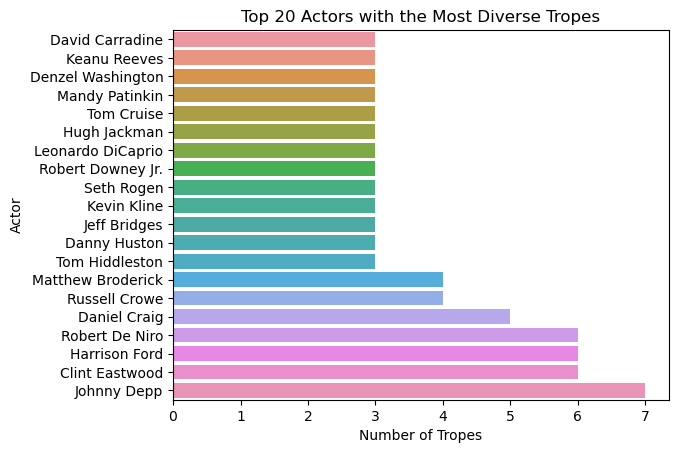

In [7]:
sns.barplot(data = tvtropes_per_actor.tail(20), x="num_tropes", y="actor", orient='h')
plt.xlabel('Number of Tropes')
plt.ylabel('Actor')
plt.title('Top 20 Actors with the Most Diverse Tropes')
plt.show()

### Analyse frequence of tropes when joined

In [81]:
tvtropes_personas_std = tvtropes_personas.copy()
tvtropes_personas_std['movie_name_standardized'] = tvtropes_personas_std['movie_name'].str.lower()

In [82]:
movies_std = movies.copy()
movies_std['movie_name_standardized'] = movies_std['movie_name'].str.lower()

In [83]:
movies_personas = movies_std.merge(tvtropes_personas_std, on='movie_name_standardized', how='inner')

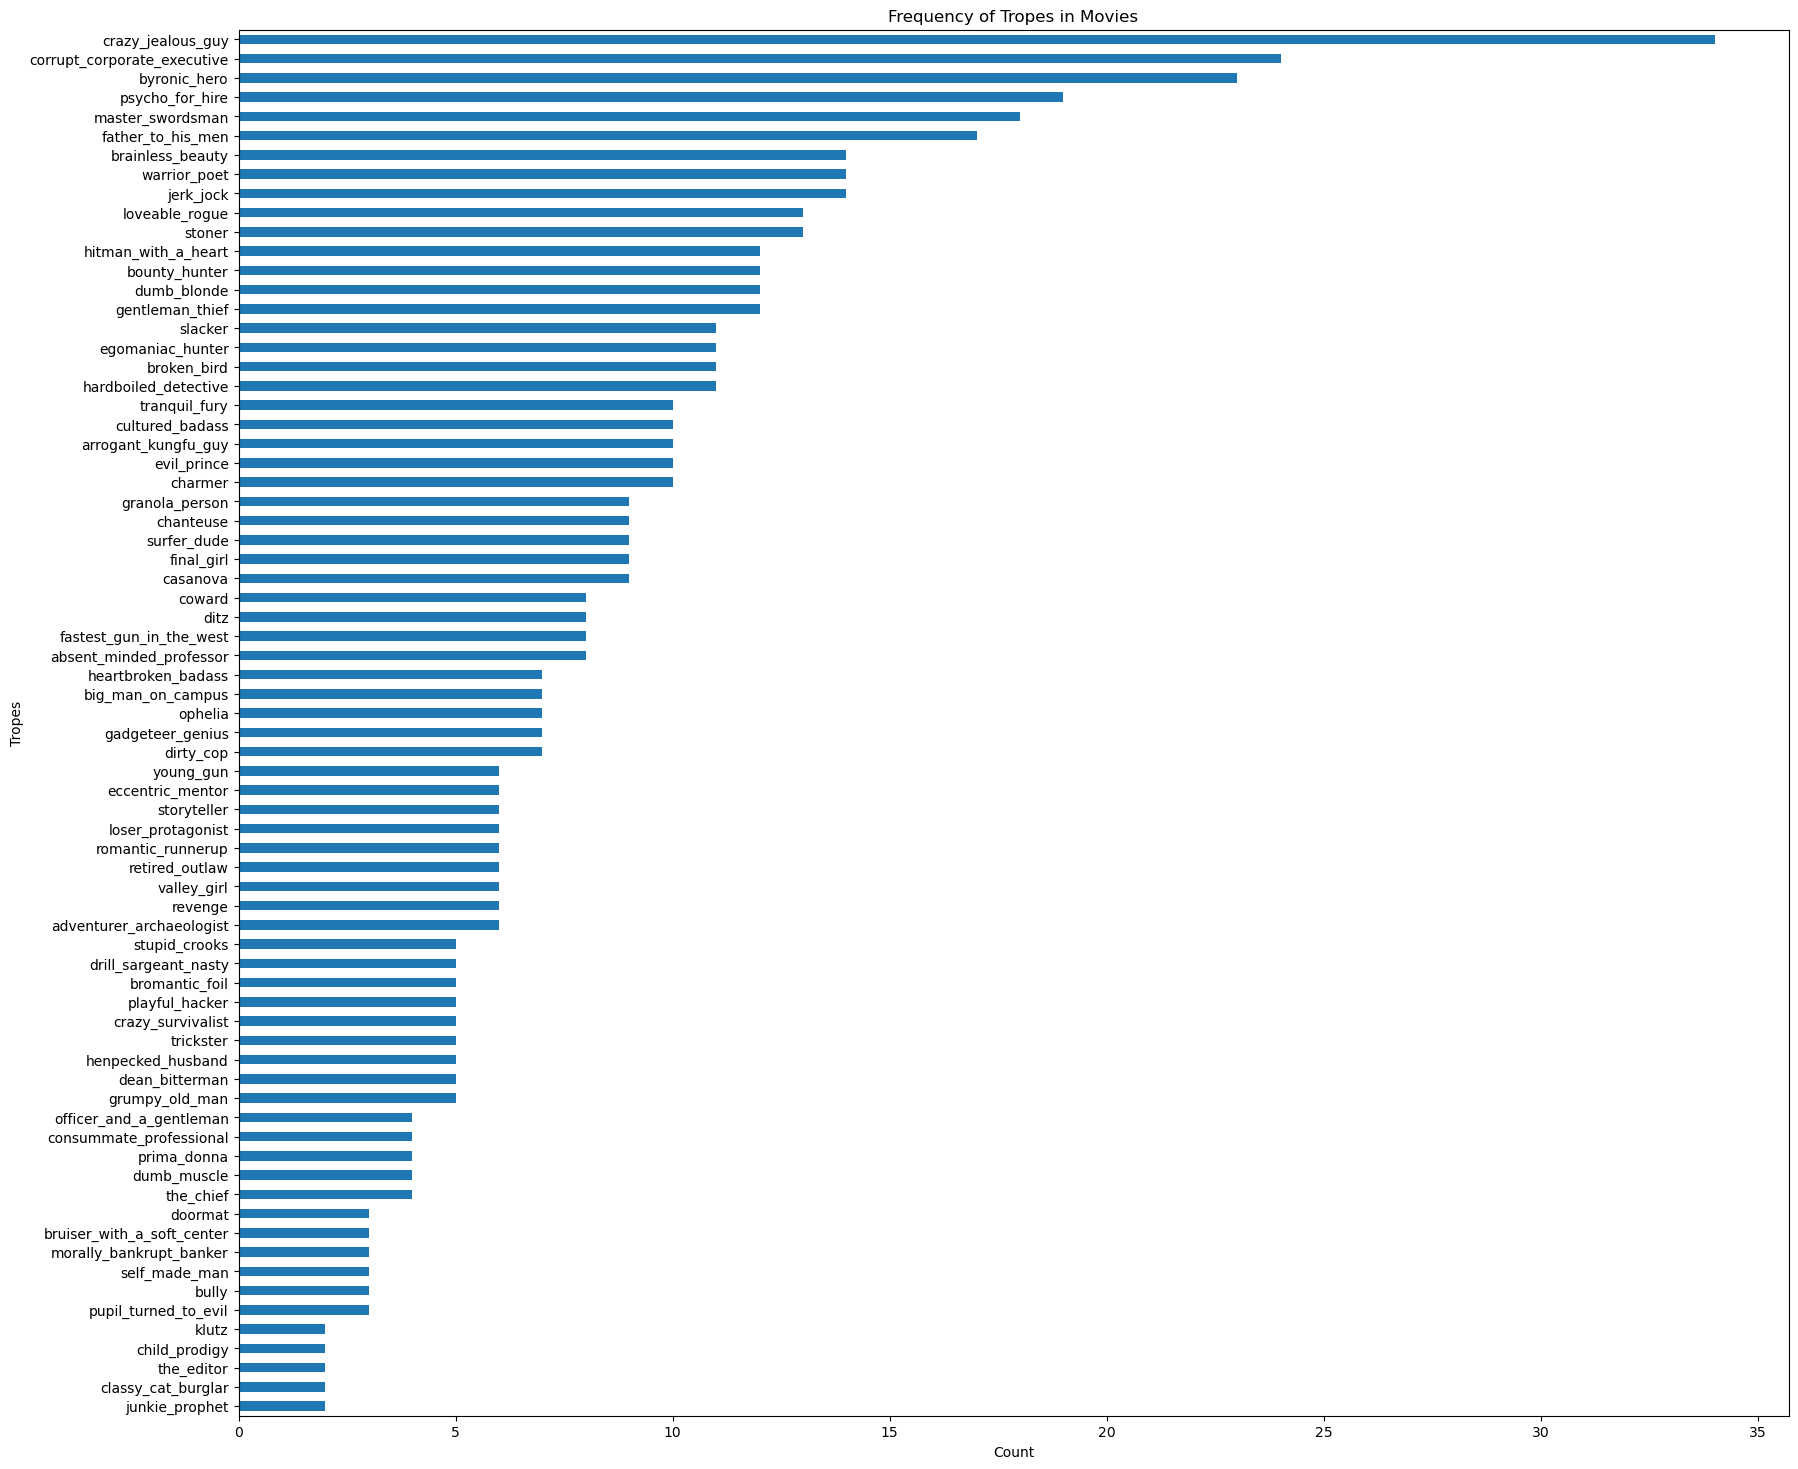

In [107]:
trope_value_counts = movies_personas['trope'].value_counts()

plt.figure(figsize=(20, 18))
trope_value_counts.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Tropes')
plt.title('Frequency of Tropes in Movies')
plt.gca().invert_yaxis()
plt.show()

## CMU personas

In [77]:
cmu_personas = load_personas()

In [79]:
cmu_personas.sample(5)

,freebase_id,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib
110613,e20,32544504,Fareb,child,the child,6,23,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
86462,e14,26699606,Santhanagopalam,she,his neighbor who believes that its his ghost a...,3,2,"[0.0, 0.01, 0.22, 0.15, 0.0, 0.02, 0.01, 0.02,..."
173571,e22,9257011,Top Cat and the Beverly Hills Cats,dogcatcher,the dogcatcher,6,29,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
125914,e5,3835239,The Power Within,jock,the top jock 's,4,34,"[0.0, 0.04, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0..."
14138,e24,12211624,A Flintstone Family Christmas,boss,him,3,5,"[0.0, 0.02, 0.01, 0.02, 0.0, 0.54, 0.0, 0.0, 0..."


In [84]:
cmu_personas[cmu_personas.full_name.str.contains("jealous")]

,freebase_id,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib
18,e7,10004055,Entertaining Mr Sloane,Ed,a jealous Ed,3,2,"[0.0, 0.0, 0.38, 0.0, 0.0, 0.01, 0.03, 0.01, 0..."
799,e10,1013377,Pretty Baby,mother,"her mother , which makes her jealous",3,14,"[0.0, 0.0, 0.12, 0.36, 0.0, 0.0, 0.0, 0.01, 0...."
5516,e3,10815122,The Victim,son,the jealous son,6,15,"[0.0, 0.0, 0.0, 0.03, 0.03, 0.0, 0.01, 0.0, 0...."
8346,e9,1126572,What a Girl Wants,daughter,"her jealous daughter , who are bent on ruining...",3,46,"[0.0, 0.0, 0.09, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0..."
12786,/m/09tdyqc,11993205,Hurricane,Charlotte Bruckner,Captain Bruckner s jealousy over his daughter ...,18,28,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
37078,e3,16811312,Very Blue Beard,she,His overly jealous wife,4,25,"[0.0, 0.02, 0.01, 0.06, 0.0, 0.0, 0.0, 0.0, 0...."
37241,/m/04dgvyy,16852170,Bad Girls From Valley High,Danielle,a jealous Danielle,28,45,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
38263,e2,1708475,Born to Kill,boyfriend,an insanely jealous man,6,41,"[0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.03, 0.06, 0...."
42846,e17,180993,"Now, Voyager",wife,"his wife , a manipulative , jealous woman who ...",4,49,"[0.0, 0.0, 0.3, 0.03, 0.0, 0.0, 0.01, 0.0, 0.0..."
44511,e8,18501121,End of the World,father,"Genevieve 's father , jealous of the wealthy M...",3,28,"[0.0, 0.0, 0.14, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0..."
